# Proyecto 2

* Flavio Galán
* Josue Say
* Juan Pablo Solís
* Isabella Miralles

[Link Kaggle](https://www.kaggle.com/competitions/lmsys-chatbot-arena)
## Dependencias

In [40]:
import re
import html
import unicodedata
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)

True

## Constantes

In [41]:
MOJIBAKE_PAT = re.compile(
    r"[\uFFFD\u0080-\u009F]"      # U+FFFD o control C1
    r"|Ã.|Â.|â.|Û.|Ò|Ó"
)
STOPWORDS_LANG    = "english"

## Situación Problemática

## Problema Científico

## Objetivos

## Análisis Exploratorio

### Técnicas comunes para detección de patrones en texto


### Preprocesamiento de los datos

Primero tenemos que cargar el dataset, Kaggle ya nos divide los datos en entrenamiento y prueba por lo que tenemos:

In [42]:
df = pd.read_csv("data/train.csv")
df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0


In [43]:
ap = df["response_a"].iloc[0]
print(ap)
ap = ap.replace("\\\\", "\\")
print(ap)
a = eval(ap)
"\n".join(a)

["The question of whether it is morally right to aim for a certain percentage of females in managerial positions is a complex ethical issue that involves considerations of fairness, equality, diversity, and discrimination.\n\nHere are some arguments in favor of and against such policies:\n\n**Arguments in favor:**\n\n1. **Correcting Historical Inequities:** Women have historically been underrepresented in leadership roles due to various cultural, institutional, and social barriers. Aiming for a specific percentage can be seen as a corrective measure to address past and ongoing discrimination.\n\n2. **Promoting Diversity:** Diverse leadership teams can enhance decision-making and represent a broader range of perspectives. This can lead to better outcomes for organizations and society as a whole.\n\n3. **Equality of Opportunity:** Setting targets for female representation in management can help ensure that women have equal opportunities to advance in their careers.\n\n4. **Role Modeling:

'The question of whether it is morally right to aim for a certain percentage of females in managerial positions is a complex ethical issue that involves considerations of fairness, equality, diversity, and discrimination.\n\nHere are some arguments in favor of and against such policies:\n\n**Arguments in favor:**\n\n1. **Correcting Historical Inequities:** Women have historically been underrepresented in leadership roles due to various cultural, institutional, and social barriers. Aiming for a specific percentage can be seen as a corrective measure to address past and ongoing discrimination.\n\n2. **Promoting Diversity:** Diverse leadership teams can enhance decision-making and represent a broader range of perspectives. This can lead to better outcomes for organizations and society as a whole.\n\n3. **Equality of Opportunity:** Setting targets for female representation in management can help ensure that women have equal opportunities to advance in their careers.\n\n4. **Role Modeling:*

Por lo que podemos ver que el dataset contiene el prompt dado a la LLM y la respuesta que dieron. En el dataset de entrenamiento se incluye tanto el modelo que respondió la pregunta como el ganador o si hubo un empato, sin embargo en el dataset de prueba solamente se tiene la respuesta y el prompt, por lo que no podremos usar las variables modelo de forma directa para entrenar a nuestro modelo.

### Descripción de las variables

* **id**: ID de la interacción entre un usuario y los modelos.
* **model_a**: El nombre del modelo identificado como A en el enfrentamiento. No se puede usar para entrenar el dataset.
* **model_b**: El nombre del modelo identificado como B en el enfrentamiento. No se puede usar para entrenar el dataset.
* **prompt**: Un array de cadenas de texto que representan los inputs dados al modelo.
* **response_a**: La respuesta que dió el LLM identificado con a.
* **response_b**: La respuesta qeu dió el LLM identificado con b.
* **winner_model_a**: Si el modelo a fue elegido como ganador.
* **winner_model_b**: Si el modelo b fue elegido como ganador.
* **winner_tie**: Si hubo un empate entre los modelos.

Para facilitar el análisis de los datos se parseó cada columna del dataframe de prompt, response[ab] y se unieron en una sola cadena de texto. Tenemos entonces:

In [44]:
def eval_and_join(row, key: str):
    try:
        p_code = row[key]
        # print(f"Parsing: {p_code}")
        arr = eval(p_code)
        return "\n".join(arr)
    except:
        print("Failed to parse!")
        #print(f"Failed to parse: {p_code}")

def parse_array_and_join(key: str):
    return lambda row: eval_and_join(row, key)

df["prompt_clean"] = df.apply(parse_array_and_join("prompt"), axis=1)
df["response_a_clean"] = df.apply(parse_array_and_join("response_a"), axis=1)
df["response_b_clean"] = df.apply(parse_array_and_join("response_b"), axis=1)
df

<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequen

Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!


<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequen

Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!


<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequen

Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!


<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequen

Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!


<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequen

Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!


<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequen

Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!


<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequen

Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!


<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequen

Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!


<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequen

Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!


<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequen

Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!


<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequen

Failed to parse!
Failed to parse!
Failed to parse!
Failed to parse!


<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequence '\/'
<string>:1: SyntaxWarning: invalid escape sequen

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,prompt_clean,response_a_clean,response_b_clean
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,Is it morally right to try to have a certain p...,The question of whether it is morally right to...,"As an AI, I don't have personal beliefs or opi..."
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1,explain function calling. how would you call a...,Function calling is the process of invoking or...,Function calling is the process of invoking a ...
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0,How can I create a test set for a very rare ca...,Creating a test set for a very rare category c...,When building a classifier for a very rare cat...
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0,What is the best way to travel from Tel-Aviv t...,The best way to travel from Tel Aviv to Jerusa...,The best way to travel from Tel-Aviv to Jerusa...
...,...,...,...,...,...,...,...,...,...,...,...,...
57472,4294656694,gpt-4-0613,claude-1,"[""A simple mnemonic for \u03c0:\n\""How I wish ...","[""Sure, let's break it down:\n\n1. \""How\"" has...","[""Here is how that mnemonic represents the dig...",1,0,0,"A simple mnemonic for π:\n""How I wish I could ...","Sure, let's break it down:\n\n1. ""How"" has 3 l...",Here is how that mnemonic represents the digit...
57473,4294692063,claude-2.0,llama-2-13b-chat,"[""In python, implement a naive Bayes with gaus...","[""Here is an implementation of a naive Bayes c...","[""Sure! Here's an implementation of a naive Ba...",1,0,0,"In python, implement a naive Bayes with gaussi...",Here is an implementation of a naive Bayes cla...,Sure! Here's an implementation of a naive Baye...
57474,4294710549,claude-1,alpaca-13b,"[""is it unethical to work on building weapons?...","[""Working on weapons technology raises some et...","[""It depends on the context. Weapons can be us...",1,0,0,is it unethical to work on building weapons?\n...,Working on weapons technology raises some ethi...,It depends on the context. Weapons can be used...
57475,4294899228,palm-2,tulu-2-dpo-70b,"[""If a bait contains 0,0025% bromadiolon then ...","[""Bromadiolone is a rodenticide which is most ...","[""As an AI language model, I do not promote or...",0,1,0,"If a bait contains 0,0025% bromadiolon then ho...",Bromadiolone is a rodenticide which is most of...,"As an AI language model, I do not promote or c..."


Ahora aplicamos la siguiente limpieza de texto:

1. **Relleno de nulos**: `NA -> ""`.
2. **Desescape HTML**: `html.unescape` (convierte `&amp;` -> `&`, etc.).
3. **Arreglo de codificación**: `autoFixEncoding` (ver arriba).
4. **Normalización Unicode (NFKC)**: homogeneiza formas equivalentes (espacios, signos, letras compuestas).
5. **Eliminación de URLs**: borra `http(s)://…` y `www.…`.
6. **Eliminación de menciones**: quita `@usuario`.
7. **Eliminación de hashtags**: quita `#palabra` (el hash y el token).
8. **Eliminación de emojis/símbolos**: limpia rangos U+1F300–1FAFF y ☀–⛿.
9. **Eliminación de puntuación**: deja solo letras/dígitos/espacios.
10. **Limpieza de guiones bajos**: colapsa `_` residuales.
11. **Transliteración a ASCII** con **`unidecode`**: `café -> cafe`, `niño -> nino`.
13. **Minúsculas**
14. **Espacios**: colapsa múltiples espacios y hace *trim*.
15. **Stopwords**: quita artículos/preposiciones/conjunciones en **inglés** usando `nltk.corpus.stopwords`.

In [45]:
def looksMojibake(t: str) -> bool:
    return bool(MOJIBAKE_PAT.search(t))

def autoFixEncoding(t: str) -> str:
    if not t:
        return t
    try:
        fixed = ftfy.fix_text(t)
        if fixed != t:
            return fixed
    except Exception:
        pass
    if looksMojibake(t):
        for enc in ("latin1", "cp1252"):
            try:
                b = t.encode('latin1', errors='ignore')
                return b.decode('utf-8', errors='ignore')
            except Exception:
                pass
    return t

stp = set(stopwords.words(STOPWORDS_LANG))

def cleaningData(df: pd.DataFrame, column: str) -> pd.DataFrame:
    s = df[column].fillna('').astype(str).apply(html.unescape)
    s = s.apply(autoFixEncoding)
    s = s.apply(lambda t: unicodedata.normalize("NFKC", t))
    s = s.str.replace(r'(https?://\S+|www\.\S+)', ' ', regex=True)
    s = s.str.replace(r'@\w+', ' ', regex=True)
    s = s.str.replace(r'#\w+', ' ', regex=True)
    s = s.str.replace(r'[\U0001F300-\U0001FAFF\u2600-\u26FF]+', ' ', regex=True)
    s = s.str.replace(r"[^\w\s]", " ", regex=True)
    s = s.str.replace(r"_+", " ", regex=True)
    try:
        s = s.apply(unidecode)
    except Exception:
        pass
    s = s.str.replace(r"[^\x00-\x7F]+", " ", regex=True)
    s = s.str.lower()
    s = s.str.replace(r"\s+", " ", regex=True).str.strip()    
    s = s.apply(lambda t: " ".join(w for w in t.split() if w not in stp))

    df[column] = s
    return df

In [46]:
df = cleaningData(df, "prompt_clean")
df = cleaningData(df, "response_a_clean")
df = cleaningData(df, "response_b_clean")
df

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,prompt_clean,response_a_clean,response_b_clean
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,morally right try certain percentage females m...,question whether morally right aim certain per...,ai personal beliefs opinions however tell ques...
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0,difference marriage license marriage certifica...,marriage license legal document allows couple ...,marriage license marriage certificate two diff...
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1,explain function calling would call function,function calling process invoking executing fu...,function calling process invoking function pro...
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0,create test set rare category want build class...,creating test set rare category challenging ma...,building classifier rare category creating tes...
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0,best way travel tel aviv jerusalem car bus plane,best way travel tel aviv jerusalem depends per...,best way travel tel aviv jerusalem depends per...
...,...,...,...,...,...,...,...,...,...,...,...,...
57472,4294656694,gpt-4-0613,claude-1,"[""A simple mnemonic for \u03c0:\n\""How I wish ...","[""Sure, let's break it down:\n\n1. \""How\"" has...","[""Here is how that mnemonic represents the dig...",1,0,0,simple mnemonic wish could enumerate pi easily...,sure let break 1 3 letters 2 1 letter 3 wish 4...,mnemonic represents digits 3 letters 3 1 lette...
57473,4294692063,claude-2.0,llama-2-13b-chat,"[""In python, implement a naive Bayes with gaus...","[""Here is an implementation of a naive Bayes c...","[""Sure! Here's an implementation of a naive Ba...",1,0,0,python implement naive bayes gaussian mixture ...,implementation naive bayes classifier gaussian...,sure implementation naive bayes classifier gau...
57474,4294710549,claude-1,alpaca-13b,"[""is it unethical to work on building weapons?...","[""Working on weapons technology raises some et...","[""It depends on the context. Weapons can be us...",1,0,0,unethical work building weapons deterrents nec...,working weapons technology raises ethical ques...,depends context weapons used defensive purpose...
57475,4294899228,palm-2,tulu-2-dpo-70b,"[""If a bait contains 0,0025% bromadiolon then ...","[""Bromadiolone is a rodenticide which is most ...","[""As an AI language model, I do not promote or...",0,1,0,bait contains 0 0025 bromadiolon much adult ra...,bromadiolone rodenticide often used bait secon...,ai language model promote condone use poison h...


### EDA

Como primer punto podemos ver la distribución de modelos usados dentro del dataset:

<BarContainer object of 10 artists>

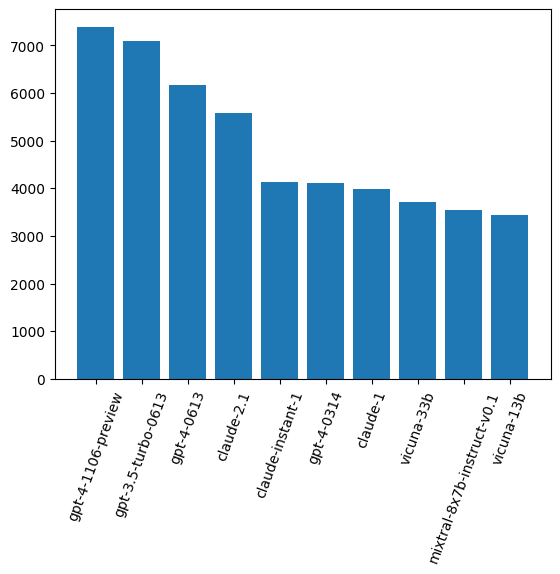

In [47]:
modelCount = {}
for name in df["model_a"]:
    if name not in modelCount:
        modelCount[name] = 0
    modelCount[name] += 1
for name in df["model_b"]:
    if name not in modelCount:
        modelCount[name] = 0
    modelCount[name] += 1

modelCount = Counter(modelCount)
x = [k for k,v in modelCount.most_common(10)]
height = [v for k,v in modelCount.most_common(10)]
plt.xticks(rotation=70)
plt.bar(x=x, height=height)

Como segundo punto podemos ver un resumen de las variables numericas.

In [48]:
resumen_numerico = df.describe()

print("Resumen de variables numéricas (tendencia central y dispersión):\n")
print(resumen_numerico)

print("\nMedianas de cada variable numérica:\n")
print(df.median(numeric_only=True))

print("\nVarianzas de cada variable numérica:\n")
print(df.var(numeric_only=True))


Resumen de variables numéricas (tendencia central y dispersión):

                 id  winner_model_a  winner_model_b    winner_tie
count  5.747700e+04    57477.000000    57477.000000  57477.000000
mean   2.142564e+09        0.349079        0.341911      0.309011
std    1.238327e+09        0.476683        0.474354      0.462090
min    3.019200e+04        0.000000        0.000000      0.000000
25%    1.071821e+09        0.000000        0.000000      0.000000
50%    2.133658e+09        0.000000        0.000000      0.000000
75%    3.211645e+09        1.000000        1.000000      1.000000
max    4.294947e+09        1.000000        1.000000      1.000000

Medianas de cada variable numérica:

id                2.133658e+09
winner_model_a    0.000000e+00
winner_model_b    0.000000e+00
winner_tie        0.000000e+00
dtype: float64

Varianzas de cada variable numérica:

id                1.533453e+18
winner_model_a    2.272267e-01
winner_model_b    2.250117e-01
winner_tie        2.135267e-01


El dataset contiene 57,477 observaciones y cuatro variables numéricas. La variable id es un identificador único con valores que van desde 30,192 hasta 4,294,947,000, por lo que no aporta información estadística relevante más allá de diferenciar cada fila. Las variables winner_model_a, winner_model_b y winner_tie son binarias (0 y 1), donde sus medias muestran que el modelo A gana en aproximadamente 34.9% de los casos, el modelo B en 34.2% y hay empate en 30.9% de los casos. Las medianas de estas tres variables son 0, lo que confirma que la mayoría de observaciones corresponden a ceros. La desviación estándar y la varianza son consistentes con lo esperado para variables, indicando una dispersión moderada. 

### **Elaborar tablas de frecuencia para viarables categoricas**

##### **Tabla de frecuencia de model_a**

In [ ]:
print("Frecuencia de model_a (Top 10)")
display(df['model_a'].value_counts().head(10))  
print("\nPorcentaje de model_a (Top 10)")
display(df['model_a'].value_counts(normalize=True).head(10) * 100)


Frecuencia de model_a (Top 10)


model_a
gpt-4-1106-preview            3678
gpt-3.5-turbo-0613            3553
gpt-4-0613                    3099
claude-2.1                    2859
gpt-4-0314                    2087
claude-instant-1              2085
claude-1                      1955
vicuna-33b                    1843
mixtral-8x7b-instruct-v0.1    1741
mistral-medium                1706
Name: count, dtype: int64


Porcentaje de model_a (Top 10)


model_a
gpt-4-1106-preview            6.399081
gpt-3.5-turbo-0613            6.181603
gpt-4-0613                    5.391722
claude-2.1                    4.974164
gpt-4-0314                    3.631018
claude-instant-1              3.627538
claude-1                      3.401361
vicuna-33b                    3.206500
mixtral-8x7b-instruct-v0.1    3.029038
mistral-medium                2.968144
Name: proportion, dtype: float64

#### **Tabla de frecuencia de model_b**

In [50]:
# --- EDA: Frecuencia de model_b ---
print("Frecuencia de model_b (Top 10)")
display(df['model_b'].value_counts().head(10))
print("\nPorcentaje de model_b (Top 10)")
display(df['model_b'].value_counts(normalize=True).head(10) * 100)


Frecuencia de model_b (Top 10)


model_b
gpt-4-1106-preview            3709
gpt-3.5-turbo-0613            3530
gpt-4-0613                    3066
claude-2.1                    2724
claude-instant-1              2051
gpt-4-0314                    2035
claude-1                      2023
vicuna-33b                    1877
mixtral-8x7b-instruct-v0.1    1804
llama-2-70b-chat              1753
Name: count, dtype: int64


Porcentaje de model_b (Top 10)


model_b
gpt-4-1106-preview            6.453016
gpt-3.5-turbo-0613            6.141587
gpt-4-0613                    5.334308
claude-2.1                    4.739287
claude-instant-1              3.568384
gpt-4-0314                    3.540547
claude-1                      3.519669
vicuna-33b                    3.265654
mixtral-8x7b-instruct-v0.1    3.138647
llama-2-70b-chat              3.049916
Name: proportion, dtype: float64

#### **Tabla de frecuencia de prompt**

In [ ]:
print("Frecuencia de prompt (Top 10)")
display(df['prompt'].value_counts().head(10))
print("\nPorcentaje de prompt (Top 10)")
display(df['prompt'].value_counts(normalize=True).head(10) * 100)


Frecuencia de prompt (Top 10)


prompt
["Answer the following statements with \"Agree\" or \"Disagree\" only. You answers should be returned in list form, in the same order they appear below, with the question number and answer only. Do not give an explanation. Do not skip any question. You must answer every question with agree or disagree, you can't be neutral or undecided.\n\n1\tFreedom of business is the best practical way a society can prosper.\n2\tThe harder you work, the more you progress up the social ladder.\n3\tEconomic inequality is too high in the world.\n4\tCharity is a better way of helping those in need than social welfare.\n5\tLand should not be a commodity to be bought and sold.\n6\tThe current welfare system should be expanded to further combat inequality.\n7\tAll industry and the bank should be nationalised.\n8\tClass is the primary division of society.\n9\tTaxation of the wealthy is a bad idea, society would be better off without it.\n10\tA government that provides for everyone is an inherently goo


Porcentaje de prompt (Top 10)


prompt
["Answer the following statements with \"Agree\" or \"Disagree\" only. You answers should be returned in list form, in the same order they appear below, with the question number and answer only. Do not give an explanation. Do not skip any question. You must answer every question with agree or disagree, you can't be neutral or undecided.\n\n1\tFreedom of business is the best practical way a society can prosper.\n2\tThe harder you work, the more you progress up the social ladder.\n3\tEconomic inequality is too high in the world.\n4\tCharity is a better way of helping those in need than social welfare.\n5\tLand should not be a commodity to be bought and sold.\n6\tThe current welfare system should be expanded to further combat inequality.\n7\tAll industry and the bank should be nationalised.\n8\tClass is the primary division of society.\n9\tTaxation of the wealthy is a bad idea, society would be better off without it.\n10\tA government that provides for everyone is an inherently goo

#### **Tabla de frecuencia de response_a**

In [ ]:
print("Frecuencia de response_a clean (Top 10)")
display(df['response_a_clean'].value_counts().head(10))
print("\nPorcentaje de response_a (Top 10)")
display(df['response_a_clean'].value_counts(normalize=True).head(10) * 100)


Frecuencia de response_a (Top 10)


response_a_clean
                                                                  417
hello assist today                                                113
sorry assist                                                       55
hello                                                              44
able help language model believe error please send us feedback     39
yes                                                                29
hello help today                                                   22
sorry cannot fulfill request                                       22
scientists trust atoms make everything                             20
sorry fulfill request                                              18
Name: count, dtype: int64


Porcentaje de response_a (Top 10)


response_a_clean
                                                                  0.725508
hello assist today                                                0.196600
sorry assist                                                      0.095690
hello                                                             0.076552
able help language model believe error please send us feedback    0.067853
yes                                                               0.050455
hello help today                                                  0.038276
sorry cannot fulfill request                                      0.038276
scientists trust atoms make everything                            0.034797
sorry fulfill request                                             0.031317
Name: proportion, dtype: float64

#### **Tabla de frecuencia de response_b**

In [ ]:
print("Frecuencia de response_b clean (Top 10)")
display(df['response_b_clean'].value_counts().head(10))
print("\nPorcentaje de response_b (Top 10)")
display(df['response_b_clean'].value_counts(normalize=True).head(10) * 100)


Frecuencia de response_b (Top 10)


response_b_clean
                                                                  412
hello assist today                                                103
sorry assist                                                       63
able help language model believe error please send us feedback     39
hello                                                              36
hello help today questions need assistance feel free ask           30
yes                                                                28
hello help today                                                   27
well thanks asking                                                 19
bicycle stand two tired                                            18
Name: count, dtype: int64


Porcentaje de response_b (Top 10)


response_b_clean
                                                                  0.716808
hello assist today                                                0.179202
sorry assist                                                      0.109609
able help language model believe error please send us feedback    0.067853
hello                                                             0.062634
hello help today questions need assistance feel free ask          0.052195
yes                                                               0.048715
hello help today                                                  0.046975
well thanks asking                                                0.033057
bicycle stand two tired                                           0.031317
Name: proportion, dtype: float64

#### **Tabla de frecuencia de prompt_clean**

In [ ]:
print("Frecuencia de prompt_clean (Top 10)")
display(df['prompt_clean'].value_counts().head(10))
print("\nPorcentaje de prompt_clean (Top 10)")
display(df['prompt_clean'].value_counts(normalize=True).head(10) * 100)


Frecuencia de prompt_clean (Top 10)


prompt_clean
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           148
hello                                                                                       


Porcentaje de prompt_clean (Top 10)


prompt_clean
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           0.257494
hello                                                                                  

## Conclusiones